In [14]:
config=dict(K=40,J=10,obs_freq=10,F_truth=10,F_fcst=10,GCM_param=[0],ns_da=10000,
            ns=10000,ns_spinup=200,dt=0.005,si=0.005,B_loc=5,DA='EnKF',nens=1000,
            obs_density=0.2,DA_freq=10,obs_sigma=1)

In [8]:
import inspect
import matplotlib.pyplot as plt
import numpy as np
from L96_model import L96, L96s, L96_eq1_xdot, L96_2t_xdot_ydot, RK4
from DA_methods import Lin3dvar, EnKF

rng=np.random.default_rng()

def s(k,K):
    """A non-dimension coordinate from -1..+1 corresponding to k=0..K"""
    return 2 * ( 0.5 + k ) / K - 1

def dist(i,j,K):
    return abs(i-j) if abs(i-j)<=K/2 else K-abs(i-j)

def GCM(X0, F, dt, nt, param=[0]):
    time, hist, X = dt*np.arange(nt+1), np.zeros((nt+1,len(X0)))*np.nan, X0.copy()
    hist[0] = X
    
    for n in range(nt):
        X = X + dt * ( L96_eq1_xdot(X, F) - np.polyval(param, X) )

        hist[n+1], time[n+1] = X, dt*(n+1)
    return hist, time

def ObsOp(K,l_obs,t_obs,i_t):
    nobs=l_obs.shape[-1]
    H=np.zeros((nobs,K))
    H[range(nobs),l_obs[t_obs==i_t]]=1
    return H

def cov_loc(B,loc):
    B_loc=B
    K=B.shape[0]
    for i in range(B.shape[0]):
        for j in range(B.shape[1]):
            if dist(i,j,K)>loc:
                B_loc[i,j]=0
    return B_loc
# print( inspect.getsource(L96) )
# print( inspect.getsource(L96s) )
# print( inspect.getsource(RK4) )

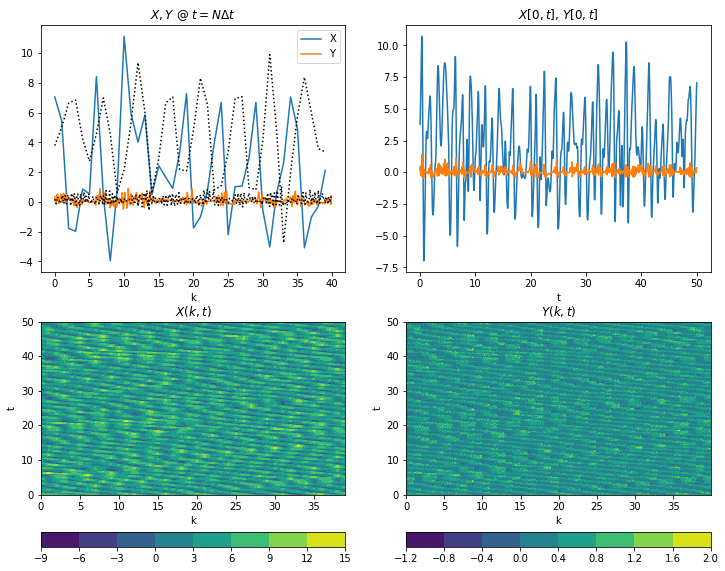

In [3]:
M_truth = L96(config['K'], config['J'], F=config['F_truth'], dt=config['dt'])
M_truth.set_state(rng.standard_normal((config['K'])), 0*M_truth.j)
X_spinup,Y_spinup,t_spinup = M_truth.run(config['si'], config['si']*config['ns_spinup'])
X_init=X_spinup[-1,:]
Y_init=Y_spinup[-1,:]

M_truth.set_state(X_init, Y_init)
X_truth,Y_truth,t_truth = M_truth.run(config['si'], config['si']*config['ns'])
# print(X_truth.shape,Y_truth.shape,t_truth.shape)

B_clim = np.cov(X_truth.T)
                
plt.figure(figsize=(12,10))
plt.subplot(221); # Snapshot of X[k]
plt.plot(M_truth.k, X_truth[-1,:], label='X');
plt.plot(M_truth.j/M_truth.J, Y_truth[-1,:], label='Y')
plt.legend(); plt.xlabel('k'); plt.title('$X,Y$ @ $t=N\Delta t$');
plt.plot(M_truth.k, X_truth[0,:], 'k:')
plt.plot(M_truth.j/M_truth.J, Y_truth[0,:], 'k:')
plt.subplot(222); # Sample time-series X[0](t), Y[0](t)
plt.plot(t_truth, X_truth[:,0], label='X');
plt.plot(t_truth, Y_truth[:,0], label='Y');
plt.xlabel('t'); plt.title('$X[0,t]$, $Y[0,t]$');
plt.subplot(223); # Full model history of X
plt.contourf(M_truth.k,t_truth,X_truth); plt.colorbar(orientation='horizontal'); plt.xlabel('k'); plt.ylabel('t'); plt.title('$X(k,t)$');
plt.subplot(224); # Full model history of Y
plt.contourf(M_truth.j/M_truth.J,t_truth,Y_truth); plt.colorbar(orientation='horizontal'); plt.xlabel('k'); plt.ylabel('t'); plt.title('$Y(k,t)$');

In [4]:
t_obs=np.tile(np.arange(0,config['ns_da'],config['obs_freq']),[int(config['K']*config['obs_density']),1]).T
l_obs=np.zeros(t_obs.shape,dtype='int')
for i in range(l_obs.shape[0]):
    l_obs[i,:]=rng.choice(config['K'], int(config['K']*config['obs_density']), replace=False)
# l_obs=rng.integers(0,config['K'],t_obs.shape)
# l_obs=np.tile(np.arange(0,config['K']),[t_obs.shape[0],1])
X_obs=X_truth[t_obs,l_obs]+config['obs_sigma']*rng.standard_normal(t_obs.shape)
print(X_obs.shape)
R = config['obs_sigma']**2*np.eye(int(config['K']*config['obs_density']))

# plt.figure(figsize=[6,4])
# plt.scatter(t_obs,X_obs)

(1000, 8)


In [15]:
B_loc=cov_loc(B_clim,config['B_loc'])

X_inc=np.zeros((config['DA_freq']+1,config['K'],config['nens']))

i_t=0
ensX=X_init[None,:,None]+rng.standard_normal((1,config['K'],config['nens']))
X_post=ensX[0,...]

for cycle in np.arange(0,config['ns_da']/config['DA_freq'],dtype='int'):
# for cycle in np.arange(0,1,dtype='int'):
    
    ensX_fcst=np.zeros((config['DA_freq']+1,config['K'],config['nens']))
    for n in range(config['nens']):
        ensX_fcst[...,n] = GCM(X_post[:,n], config['F_fcst'], config['dt'], config['DA_freq'], config['GCM_param'])[0]
        
    X_prior=np.squeeze(ensX_fcst[-1,...])
    
    if config['DA']=='EnKF':
        H=ObsOp(config['K'],l_obs,t_obs,i_t)
        X_prior_mean=np.mean(X_prior,1)
        B_ens = np.cov(X_prior)
        B_ens_loc = cov_loc(B_ens,config['B_loc'])
#         print(X_prior_mean)
#         print(l_obs[t_obs==i_t])
#         print(X_obs[t_obs==i_t])
#         B = (1/(config['nens']-1)) * (X_prior - X_prior_mean[:,None]) @ (X_prior - X_prior_mean[:,None]).T
        X_post=EnKF(X_prior,X_obs[t_obs==i_t],H,R,B_ens_loc)[0]
#         print(np.mean(X_post,1))
    elif config['DA']=='3DVar':
        H=ObsOp(config['K'],l_obs,t_obs,i_t)
        X_post=Lin3dvar(X_prior,X_obs[t_obs==i_t],H,R,B_loc,3)
        X_post=X_post[:,None]
    elif config['DA']=='Replace':
        X_post=X_prior
        X_post[l_obs[t_obs==i_t]]=X_obs[t_obs==i_t]
    elif config['DA']=='None':
        X_post=X_prior
    
    ensX_fcst[-1,:,:]=X_post
    i_t=i_t+config['DA_freq']
    ensX=np.concatenate((ensX,ensX_fcst[1:None,...]))
    

meanX=np.mean(ensX,axis=-1)
print(X_truth[0:(config['ns_da']+1),:].shape)
fig, axes=plt.subplots(2,2,figsize=(12,10))
clim=np.max(np.abs(np.mean(ensX,axis=-1)-X_truth[0:(config['ns_da']+1),:]))
ch=axes[0,0].contourf(M_truth.k,t_truth[0:(config['ns_da']+1)],meanX-X_truth[0:(config['ns_da']+1),:],
                           cmap='bwr',vmin=-clim,vmax=clim,extend='neither');
plt.colorbar(ch,ax=axes[0,0],orientation='horizontal'); 
axes[0,0].set_xlabel('s'); axes[0,0].set_ylabel('t'); axes[0,0].set_title('X - X_truth');
axes[0,1].plot(t_truth[0:(config['ns_da']+1)], np.sqrt(((meanX-X_truth[0:(config['ns_da']+1),:])**2).mean(axis=-1)),label='RMSE'); 
axes[0,1].plot(t_truth[0:(config['ns_da']+1)], np.mean(np.std(ensX,axis=-1),axis=-1),label='Spread'); 
axes[0,1].legend()
axes[0,1].set_xlabel('t'); axes[0,1].set_title('RMSE (X - X_truth)');
axes[1,0].plot(M_truth.k, np.sqrt(((meanX-X_truth[0:(config['ns_da']+1),:])**2).mean(axis=0))); 
axes[1,0].set_xlabel('s'); axes[1,0].set_title('RMSE (X - X_truth)');
axes[1,1].text(0.1,0.1,'GCM param={}\nRMSE={:3f}\nDA={}\nEnsemble={}\nDA_freq={}\nB_loc={}\nobs_density={}\nobs_sigma={}\nF_truth={}\nF_fcst={}\nobs_freq={}'.\
               format(config['GCM_param'],np.sqrt(((meanX-X_truth[0:(config['ns_da']+1),:])**2).mean()),config['DA'],
                      config['nens'],config['DA_freq'],config['B_loc'],config['obs_density'],config['obs_sigma'],
                      config['F_truth'],config['F_fcst'],config['obs_freq']),
               fontsize=15)

exp_number=np.random.randint(1,10000)
f = open('config_{0}.txt'.format(exp_number),"w")
f.write( str(config) )
f.close()
plt.savefig('fig_{0}.jpg'.format(exp_number))

KeyboardInterrupt: 